## Introduction
This notebook analyzes three different types of regression modeling:  OLS, Ridge and Lasso.  The data used is crime data for the state of South Carolina. The data is cleaned and some knew features are created to possibly build a more accurate model that has more predictive power.  The data will be divided into a training set and a test set and results are compared for the three different methods.  

The **"murder" feature is the target** feature we will try to predict in this data set.  It is converted to a binomial value in this example.

In [1]:
# importing pnadas modules
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import math

%matplotlib inline
#pd.options.display.float_format = '{:.3f}'.format
sns.set_style('white')

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

## Import and clead the data
Import the raw data and remove some unnecessary rows and columns and rename some of the columns for easier use during model building.

In [2]:
# importing raw data from excel into a pandas dataframe
df_raw = pd.read_excel('table_8_offenses_known_to_law_enforcement_south_carolina_by_city_2013.xls')
# display raw file
df_raw.head()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,SOUTH CAROLINA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson
4,Abbeville,5163,40,1,1,NaN,3,35,215,72,135,8,1


Drop some rows, rename some columns and square pop to get a pop2 column just in case we want to use this as a feature.   Also, convert data to float.

In [3]:
# setting the proper heading from the 4th row of raw data
headers = df_raw.iloc[3]

# exclude rows 1 through 4 (or rows 0, 1, 2, 3)
df_sc = pd.DataFrame(df_raw.values[4:], columns=headers)

# renaming columns
df_sc.columns = ['city', 'pop', 'vc', 'murder', 'rape1', 'rape2', 'robbery', 'aa', 'pc', 'burglary', 'lt', 'mvt', 'arson3']

# display data
df_sc.head()

,city,pop,vc,murder,rape1,rape2,robbery,aa,pc,burglary,lt,mvt,arson3
0,Abbeville,5163,40,1,1,NaN,3,35,215,72,135,8,1
1,Aiken,29965,96,1,8,NaN,32,55,1479,215,1206,58,4
2,Allendale,3272,49,2,3,NaN,5,39,150,79,64,7,1
3,Anderson,26812,278,2,21,NaN,43,212,2417,510,1767,140,10
4,Andrews,2823,26,1,3,NaN,8,14,193,51,134,8,0


In [4]:
df_sc.tail()

,city,pop,vc,murder,rape1,rape2,robbery,aa,pc,burglary,lt,mvt,arson3
142,Winnsboro,3428,14,0,4,NaN,2,8,209,22,181,6,0
143,Woodruff,4122,25,0,1,NaN,3,21,97,18,74,5,0
144,York,7927,63,0,12,NaN,6,45,341,50,280,11,2
145,1 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,2 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# removing last 2 rows of instructional data
df_sc.drop(df_sc.tail(2).index, inplace=True)
# drop the rape2 column which cantains NaN values
df_sc.drop(['rape2'], axis=1, inplace=True)

In [6]:
df_sc.tail()

,city,pop,vc,murder,rape1,robbery,aa,pc,burglary,lt,mvt,arson3
140,Williamston,4008,23,0,2,1,20,181,31,140,10,0
141,Williston,3067,16,0,0,2,14,112,39,67,6,0
142,Winnsboro,3428,14,0,4,2,8,209,22,181,6,0
143,Woodruff,4122,25,0,1,3,21,97,18,74,5,0
144,York,7927,63,0,12,6,45,341,50,280,11,2


In [7]:
df_sc.dtypes

city        object
pop         object
vc          object
murder      object
rape1       object
robbery     object
aa          object
pc          object
burglary    object
lt          object
mvt         object
arson3      object
dtype: object

Convert the columns to float in order to compare using a pairplot and possibly other data exploration methods.

In [8]:
df_sc["pop"] = [np.float(x) for x in df_sc["pop"]]
df_sc["vc"] = [np.float(x) for x in df_sc["vc"]]
df_sc["murder"] = [np.float(x) for x in df_sc["murder"]]
df_sc["rape1"] = [np.float(x) for x in df_sc["rape1"]]
df_sc["robbery"] = [np.float(x) for x in df_sc["robbery"]]
df_sc["aa"] = [np.float(x) for x in df_sc["aa"]]
df_sc["pc"] = [np.float(x) for x in df_sc["pc"]]
df_sc["burglary"] = [np.float(x) for x in df_sc["burglary"]]
df_sc["lt"] = [np.float(x) for x in df_sc["lt"]]
df_sc["mvt"] = [np.float(x) for x in df_sc["mvt"]]
df_sc["arson3"] = [np.float(x) for x in df_sc["arson3"]]

Build the pairplot.

## Data exploration
Create heatmaps and some pair plots to look at the relationships of each of the features in our dataset.

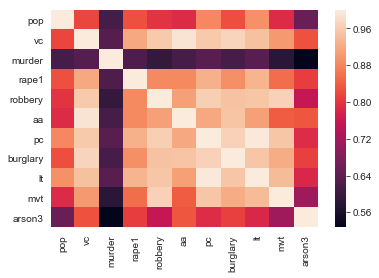

In [9]:
# Compute pairwise correlation of columns, excluding NA/null values (with .corr); then create the heatmap.
sns.heatmap(df_sc.corr())

This heatmap shows that murder is not very highly correlated with any of the features.  In other words, most of the features we have so far appear to offer about the same predictive value for murder.  Many of the feature are fairly highly correlated (above .90) and thus have overlapping significance for a standard OLS model.  It looks like 'lt' and 'pc' have the highest predictive value.

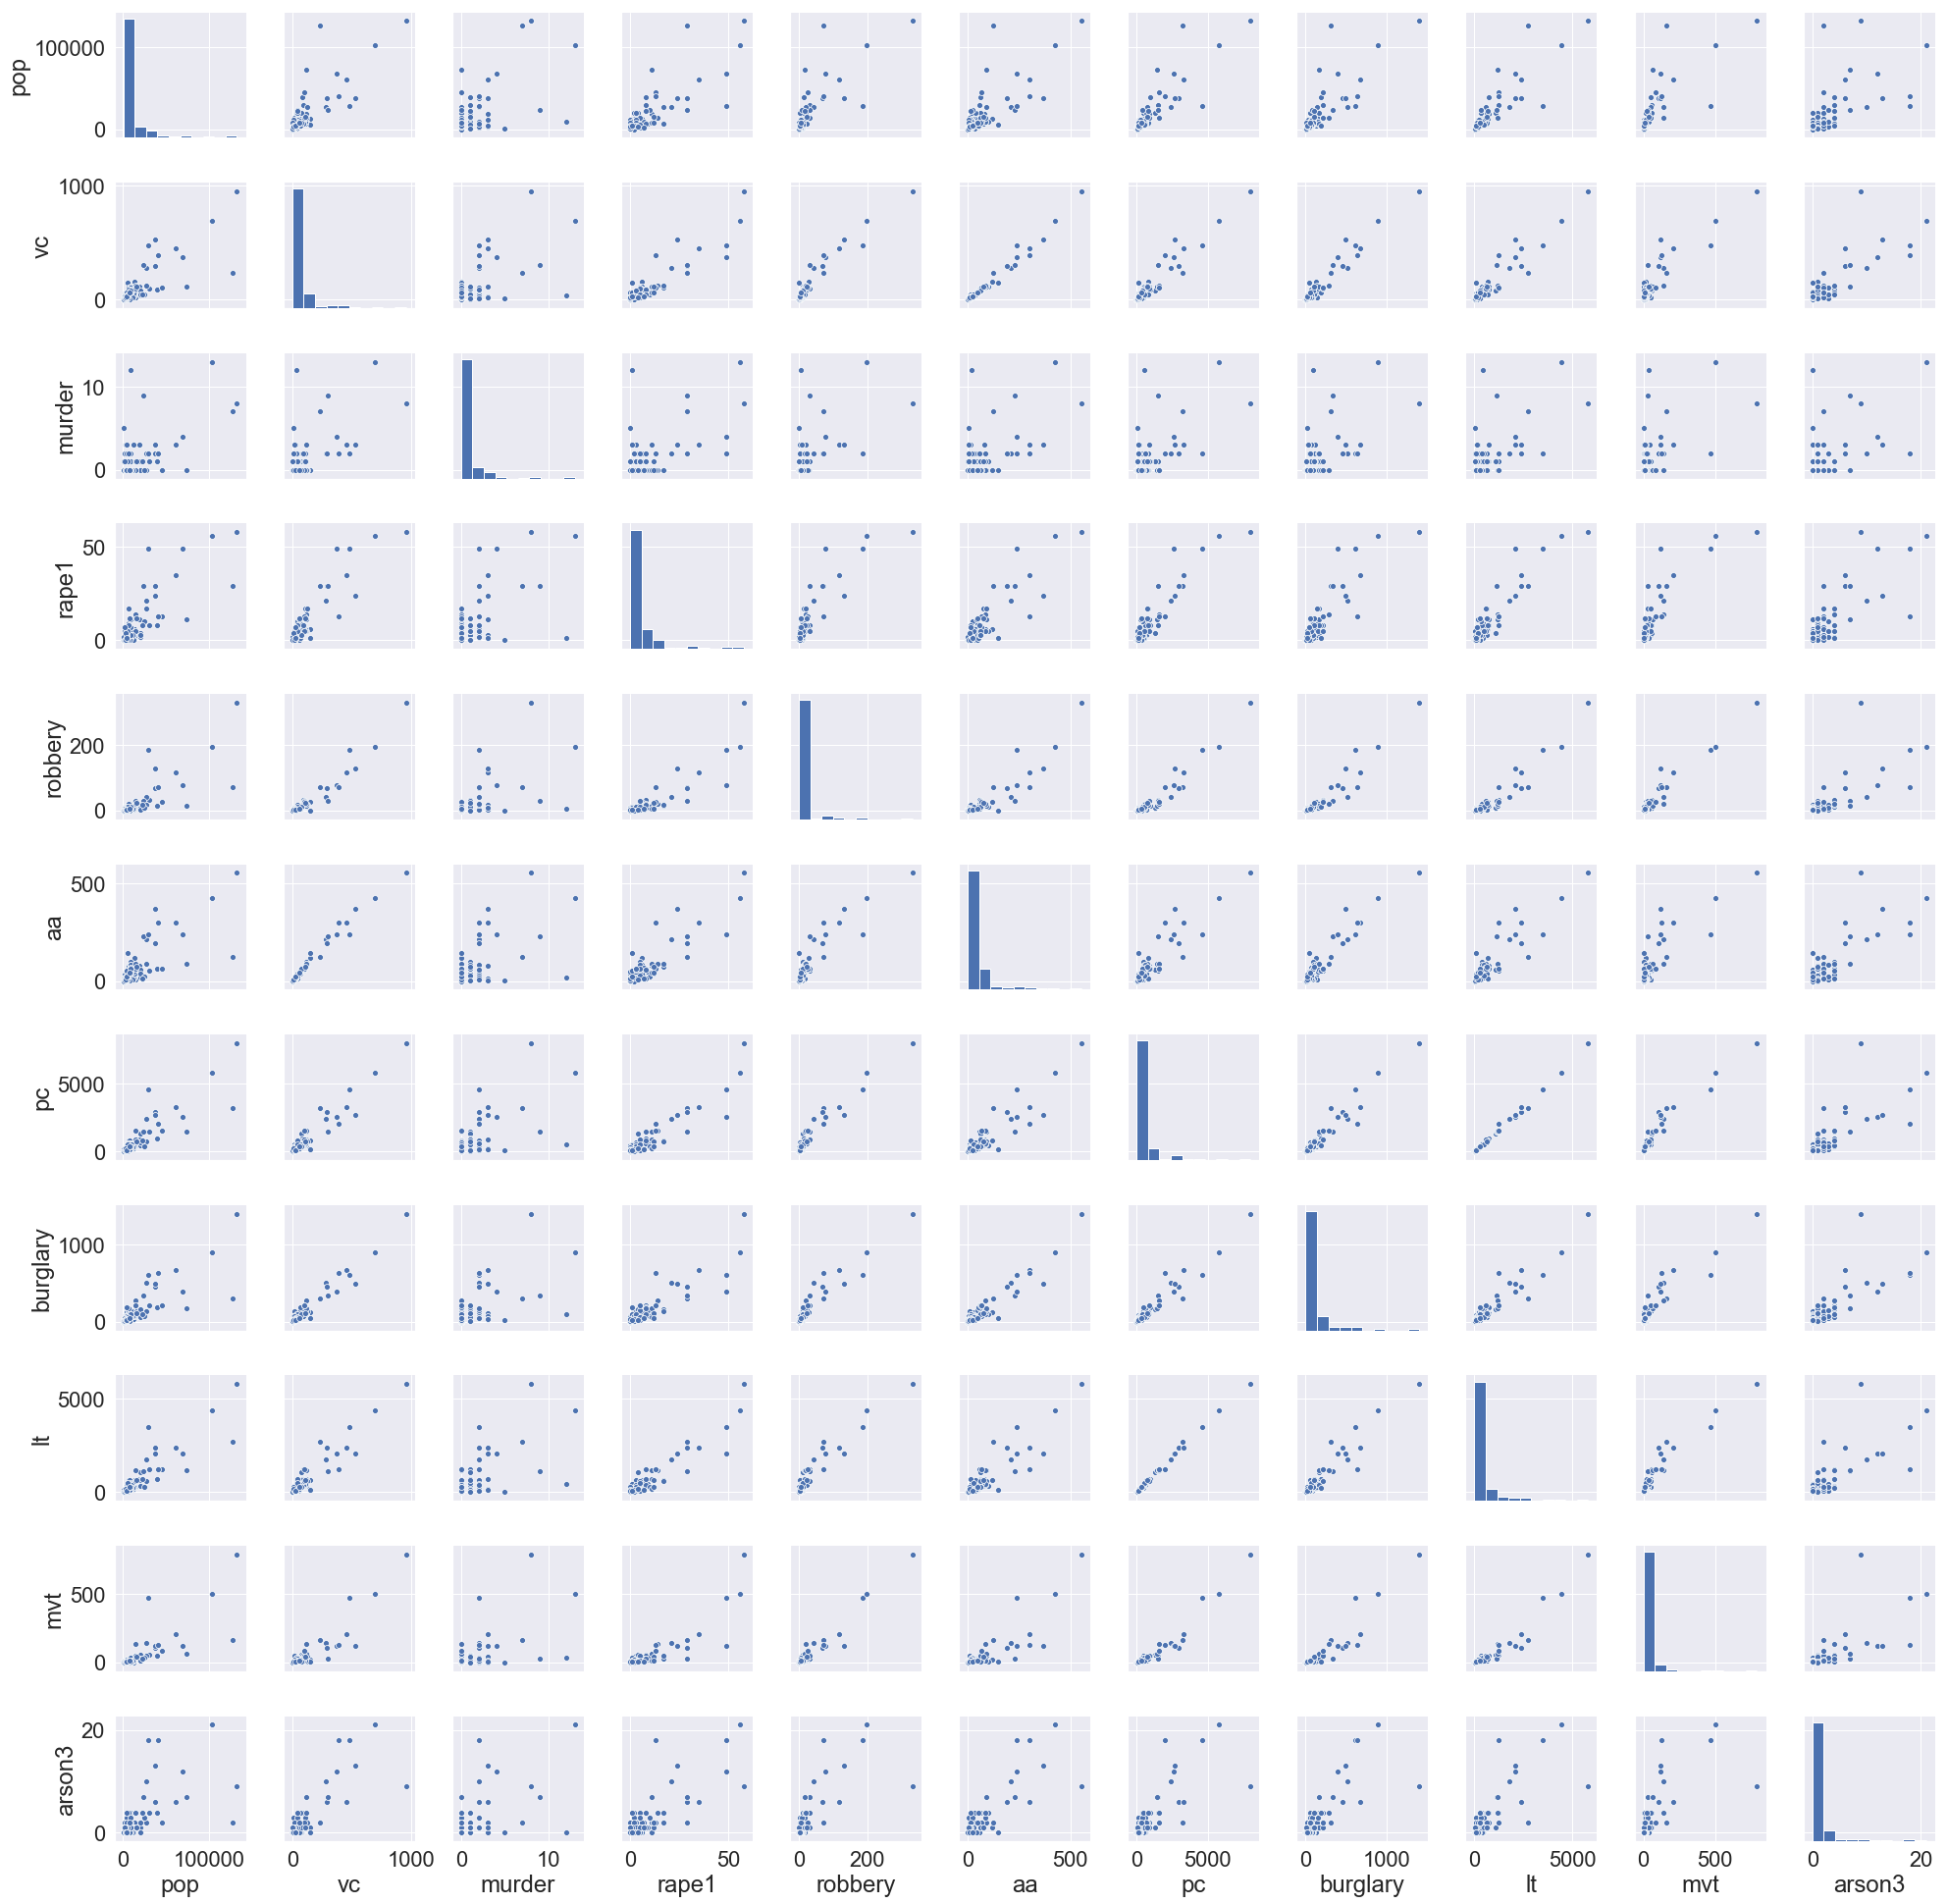

In [10]:
sns.set(font_scale=2.0)
sns.pairplot(df_sc)

This pairplot contains all of the features given in their original state.  Looking at the 'murder' column (which we will be trying to pridict), we don't see a clear trend with any of the other features - other than the fact very general trend that as one feature increases, the murder target feature increases.  None of the independent variables stand out as particularly relevant compared to the others.

In [11]:
# create more features by manipulating the existing features mathematically.
df_sc["pop2"] = [np.float(x*x) for x in df_sc["pop"]]
df_sc["pop3"] = [np.float(x*x*x) for x in df_sc["pop"]]
df_sc["pop_sqrt"] = [np.float(x**.5) for x in df_sc["pop"]]
df_sc["pop_log"] = [np.float(math.log(x)) for x in df_sc["pop"]]

# multiply the 3 columns together
df_sc['rob_aa_arson'] = df_sc.apply(lambda row: (row['robbery']*row['aa']*row['arson3']), axis=1)

In [12]:
df_sc.head()

,city,pop,vc,murder,rape1,robbery,aa,pc,burglary,lt,mvt,arson3,pop2,pop3,pop_sqrt,pop_log,rob_aa_arson
0,Abbeville,5163.0,40.0,1.0,1.0,3.0,35.0,215.0,72.0,135.0,8.0,1.0,26656569.0,1.376279e+11,71.854019,8.549273,105.0
1,Aiken,29965.0,96.0,1.0,8.0,32.0,55.0,1479.0,215.0,1206.0,58.0,4.0,897901225.0,2.690561e+13,173.104015,10.307785,7040.0
2,Allendale,3272.0,49.0,2.0,3.0,5.0,39.0,150.0,79.0,64.0,7.0,1.0,10705984.0,3.502998e+10,57.201399,8.093157,195.0
3,Anderson,26812.0,278.0,2.0,21.0,43.0,212.0,2417.0,510.0,1767.0,140.0,10.0,718883344.0,1.927470e+13,163.743702,10.196605,91160.0
4,Andrews,2823.0,26.0,1.0,3.0,8.0,14.0,193.0,51.0,134.0,8.0,0.0,7969329.0,2.249742e+10,53.131911,7.945555,0.0


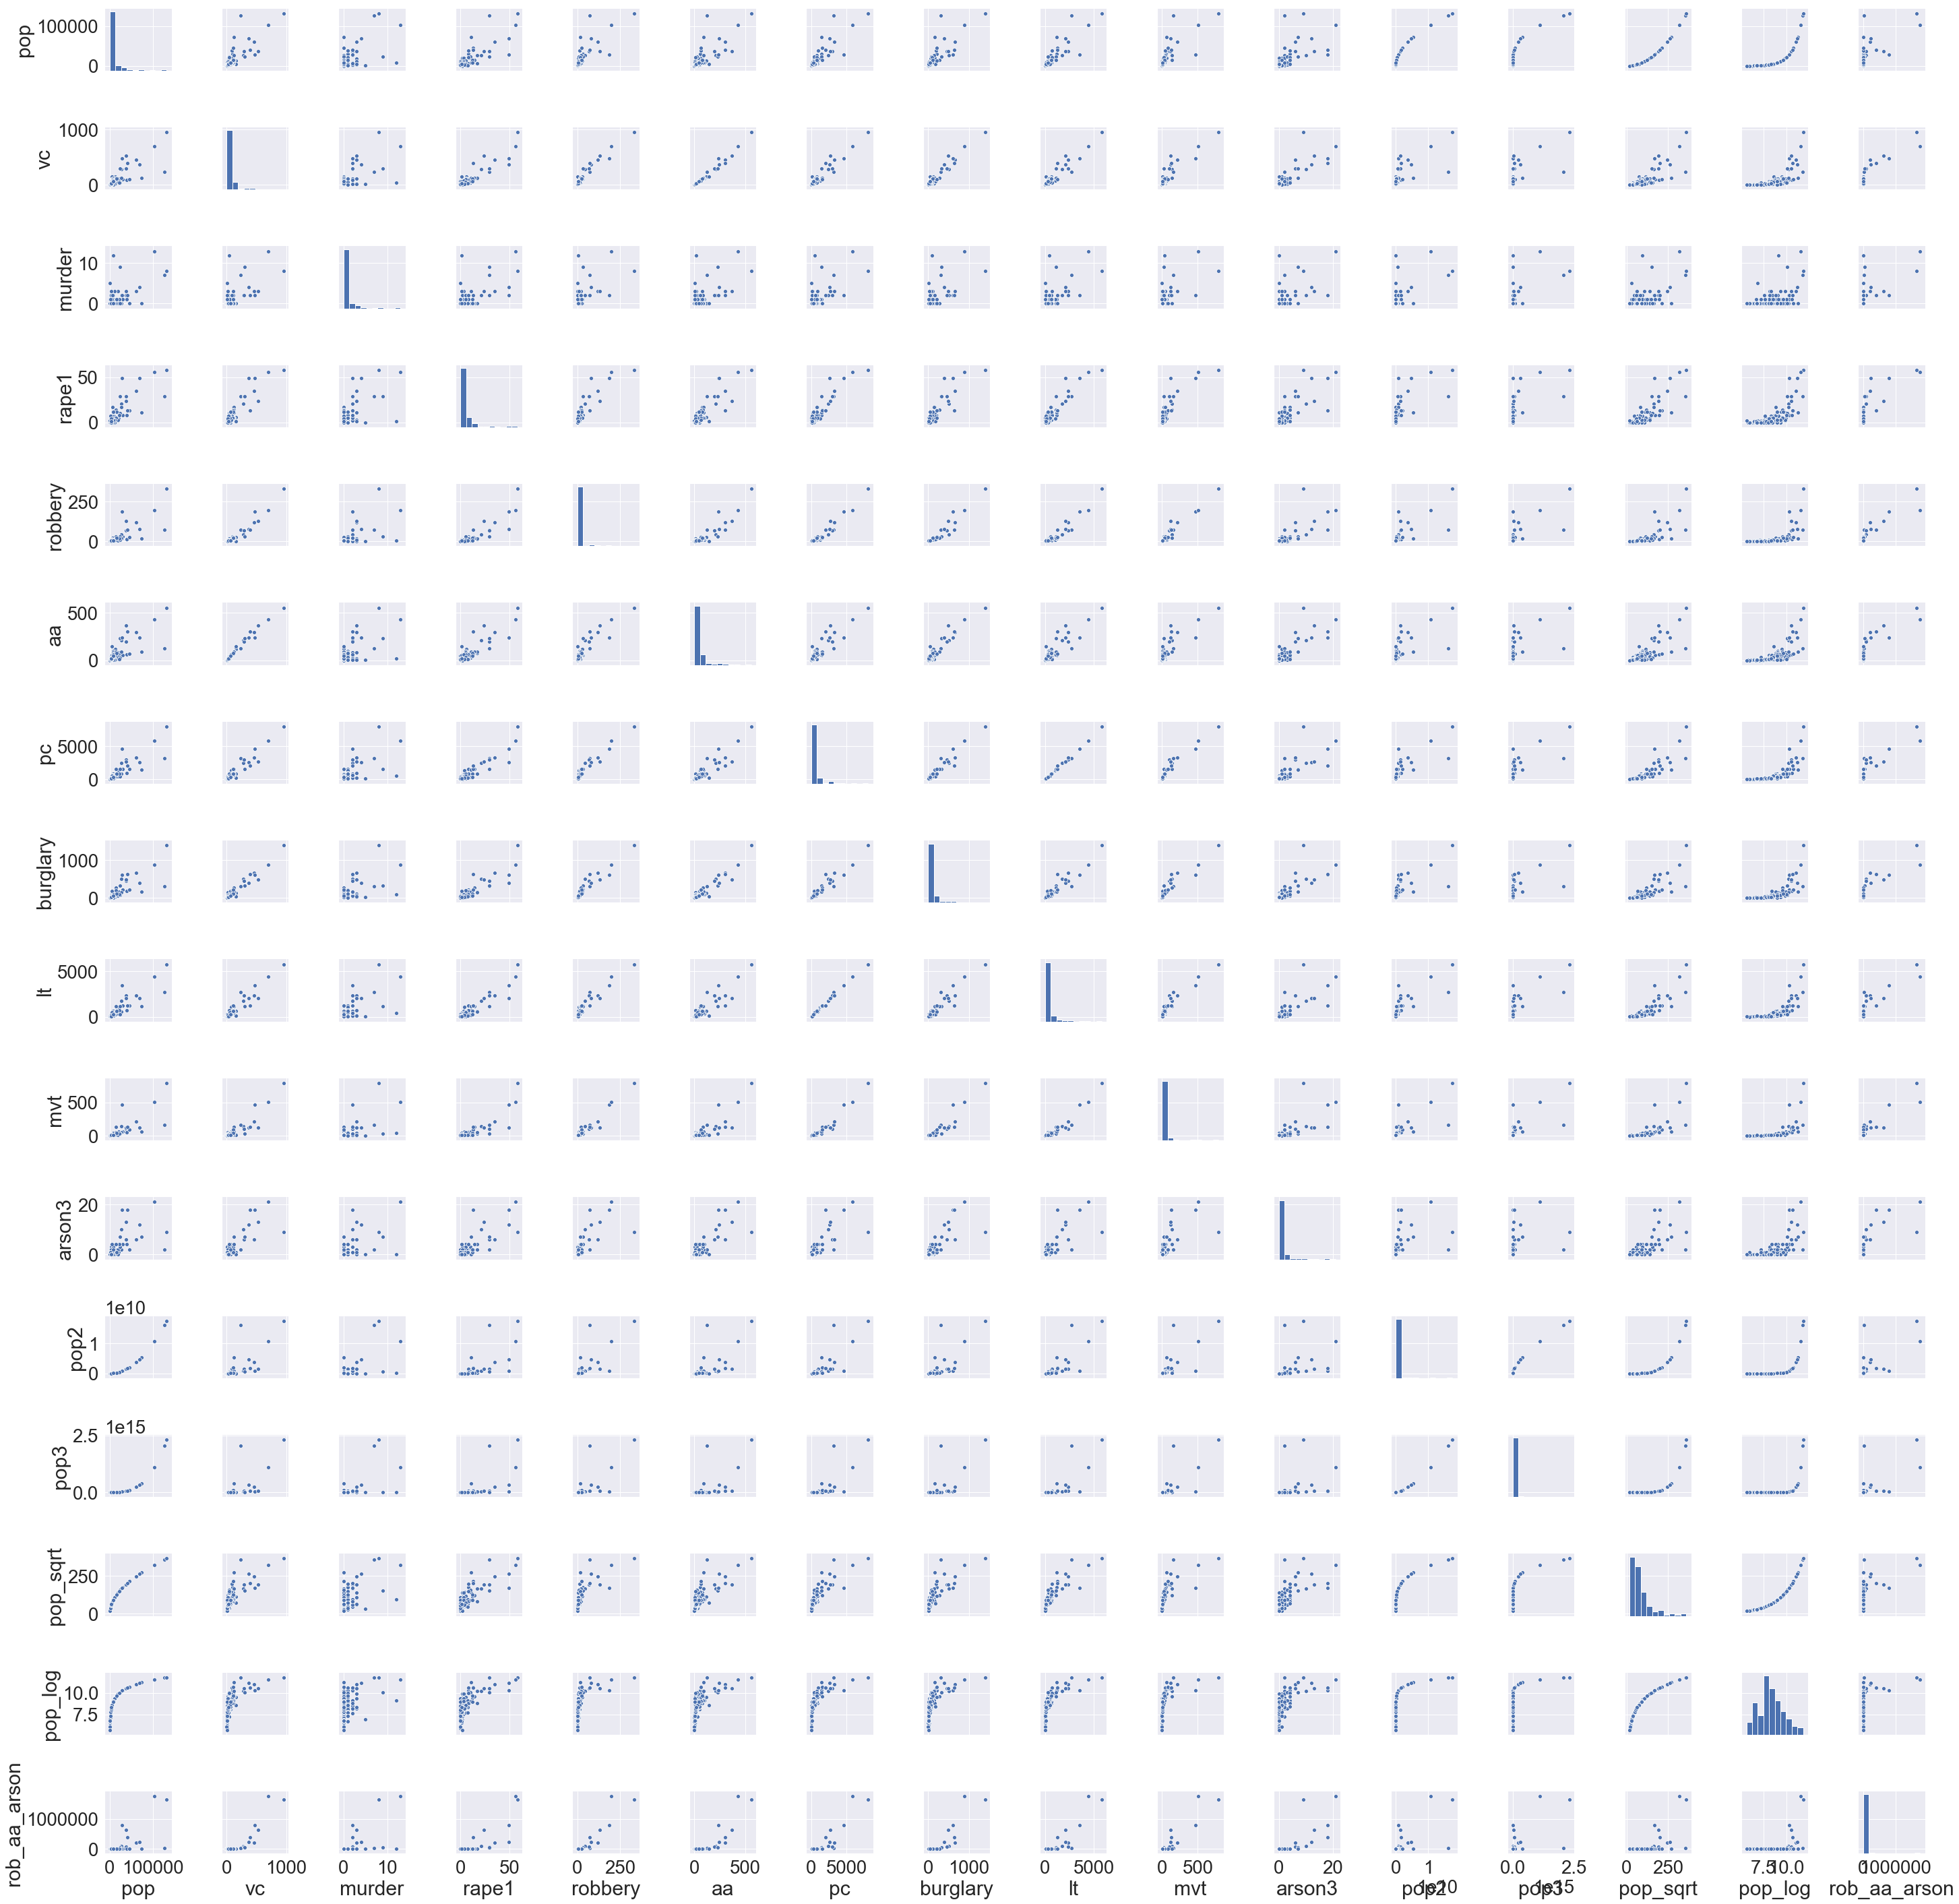

In [13]:
sns.set(font_scale=2.5)
sns.pairplot(df_sc)

The above pairplot shows all of the original features as well as the engineered features.  There still does not seem to be a strong predictive feature that stands out above the rest.

In [14]:
# If murders or robberies in greater than 0, convert to 1 else leave at 0
df_sc['murder'] = df_sc['murder'].apply(lambda x : 1 if x>0 else 0)

In [15]:
df_sc.dtypes

city             object
pop             float64
vc              float64
murder            int64
rape1           float64
robbery         float64
aa              float64
pc              float64
burglary        float64
lt              float64
mvt             float64
arson3          float64
pop2            float64
pop3            float64
pop_sqrt        float64
pop_log         float64
rob_aa_arson    float64
dtype: object

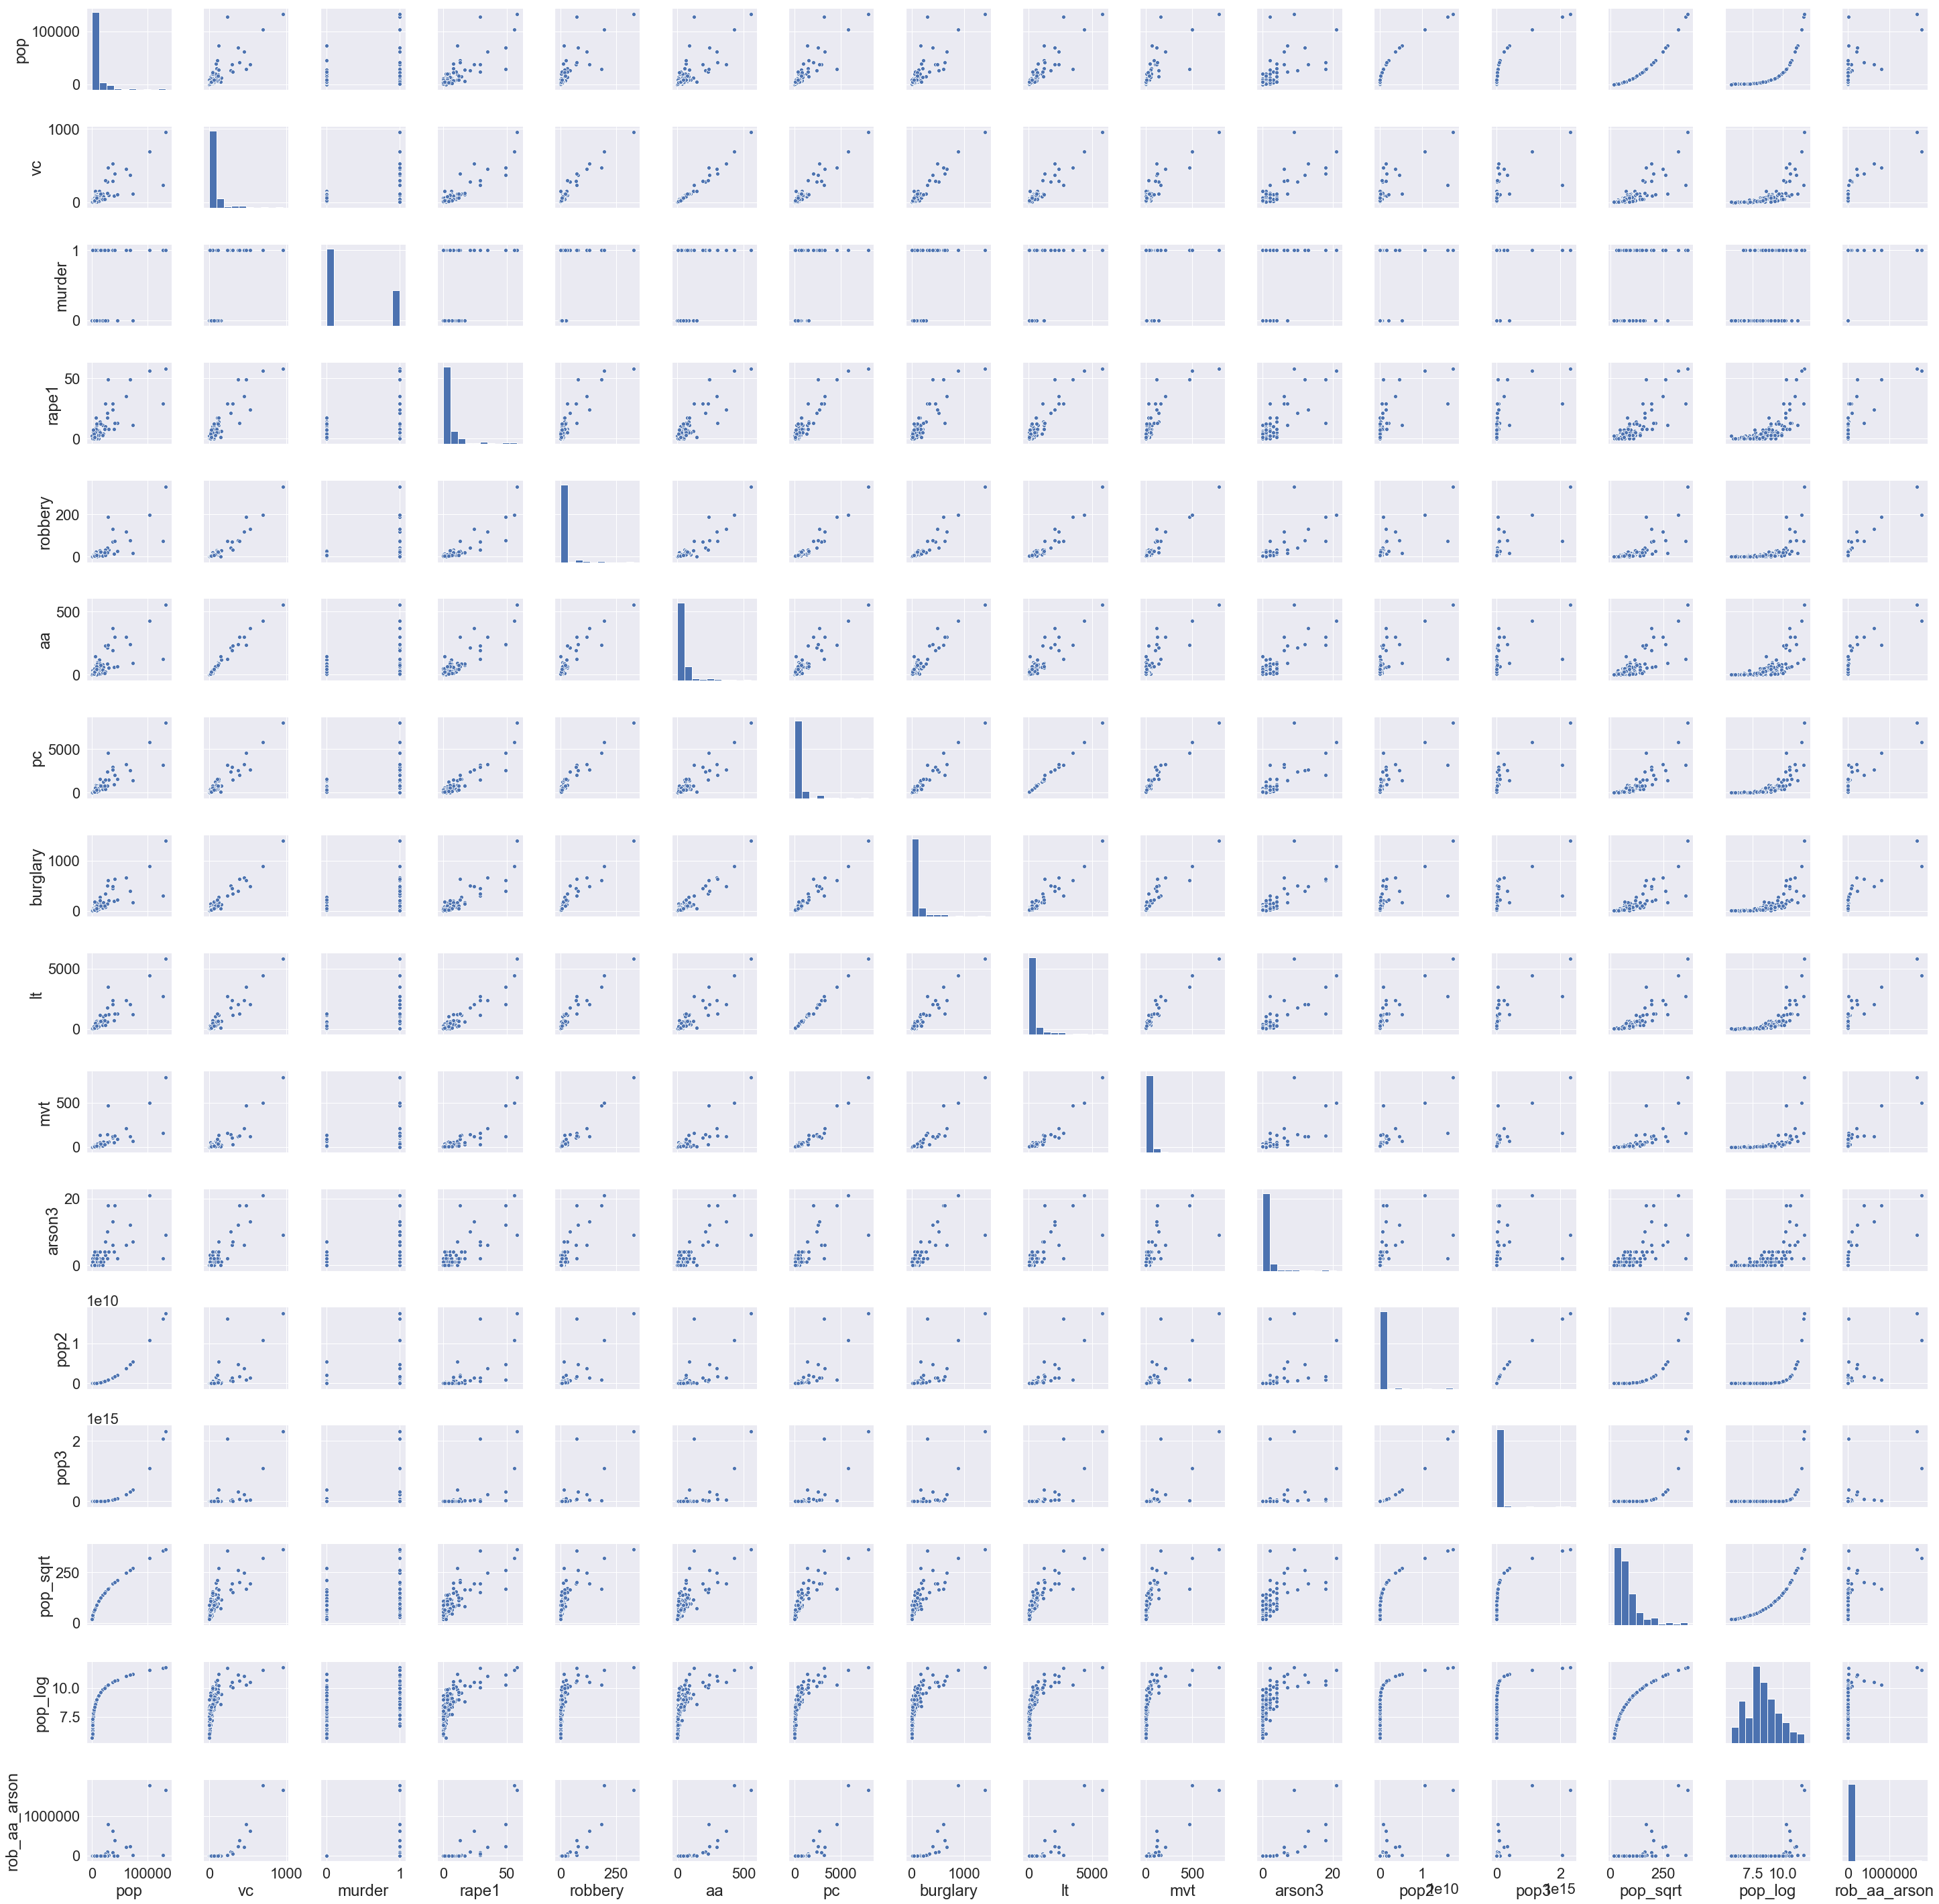

In [16]:
sns.set(font_scale=2.0)
sns.pairplot(df_sc)

The above pairplot shows the features relative to the murder target feature after murder has been changed to a binomial value.

In [17]:
df_sc.head()

,city,pop,vc,murder,rape1,robbery,aa,pc,burglary,lt,mvt,arson3,pop2,pop3,pop_sqrt,pop_log,rob_aa_arson
0,Abbeville,5163.0,40.0,1,1.0,3.0,35.0,215.0,72.0,135.0,8.0,1.0,26656569.0,1.376279e+11,71.854019,8.549273,105.0
1,Aiken,29965.0,96.0,1,8.0,32.0,55.0,1479.0,215.0,1206.0,58.0,4.0,897901225.0,2.690561e+13,173.104015,10.307785,7040.0
2,Allendale,3272.0,49.0,1,3.0,5.0,39.0,150.0,79.0,64.0,7.0,1.0,10705984.0,3.502998e+10,57.201399,8.093157,195.0
3,Anderson,26812.0,278.0,1,21.0,43.0,212.0,2417.0,510.0,1767.0,140.0,10.0,718883344.0,1.927470e+13,163.743702,10.196605,91160.0
4,Andrews,2823.0,26.0,1,3.0,8.0,14.0,193.0,51.0,134.0,8.0,0.0,7969329.0,2.249742e+10,53.131911,7.945555,0.0


## Building the model
First, we will start with an **Ordianary Least Squares** model.

In [18]:
# split the data into training and test sets
trainsize = int(df_sc.shape[0] / 2)
df_test = df_sc.iloc[trainsize:, :].copy()
df_train = df_sc.iloc[:trainsize, :].copy()

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df_train['murder'].values.reshape(-1, 1)
X = df_train[['pop', 'vc', 'rape1', 'robbery', 'aa', 'pc', 'burglary', 'lt', 'mvt', 'arson3', 
               'pop2', 'pop3', 'pop_sqrt', 'pop_log', 'rob_aa_arson']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared - train data:')
print(regr.score(X, Y))

# now set the X and Y for the test set
Y_T = df_test['murder'].values.reshape(-1, 1)
X_T = df_test[['pop', 'vc', 'rape1', 'robbery', 'aa', 'pc', 'burglary', 'lt', 'mvt', 'arson3', 
               'pop2', 'pop3', 'pop_sqrt', 'pop_log', 'rob_aa_arson']]

# check the predictive power with the test set
print('\nR-squared - test data:')
print(regr.score(X_T, Y_T))


Coefficients: 
 [[-1.63722453e-04  3.20859694e-01 -3.51384734e-01 -3.18288319e-01
  -3.22541608e-01  2.42264174e-03 -5.59080032e-03 -1.86405425e-03
   9.87749631e-03  3.87158304e-02  2.14808354e-09 -1.16018306e-14
   2.11630048e-02  6.69015100e-03 -2.98464897e-06]]

Intercept: 
 [-0.50632328]

R-squared - train data:
0.6323895612082573

R-squared - test data:
-1.5290495686991177


Now, let's use **Ridge** regression to build and test the model.

In [27]:
# split the data into training and test sets
trainsize = int(df_sc.shape[0] / 2)
df_test = df_sc.iloc[trainsize:, :].copy()
df_train = df_sc.iloc[:trainsize, :].copy()

# Instantiate and fit our model.
regr_r = linear_model.Ridge(alpha=3)
Y = df_train['murder'].values.reshape(-1, 1)
X = df_train[['pop', 'vc', 'rape1', 'robbery', 'aa', 'pc', 'burglary', 'lt', 'mvt', 'arson3', 
               'pop2', 'pop3', 'pop_sqrt', 'pop_log', 'rob_aa_arson']]
regr_r.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr_r.coef_)
print('\nIntercept: \n', regr_r.intercept_)
print('\nR-squared - train data:')
print(regr_r.score(X, Y))

# now set the X and Y for the test set
Y_T = df_test['murder'].values.reshape(-1, 1)
X_T = df_test[['pop', 'vc', 'rape1', 'robbery', 'aa', 'pc', 'burglary', 'lt', 'mvt', 'arson3', 
               'pop2', 'pop3', 'pop_sqrt', 'pop_log', 'rob_aa_arson']]

# check the predictive power with the test set
print('\nR-squared - test data:')
print(regr_r.score(X_T, Y_T))


Coefficients: 
 [[-1.54631525e-04  2.60078730e-01 -2.82978047e-01 -2.58537457e-01
  -2.61945015e-01  1.76453324e-03 -3.79273727e-03 -1.28944824e-03
   6.84671870e-03  3.72788473e-02  1.98936377e-09 -1.04706790e-14
   2.04137255e-02  1.44318143e-02 -2.12214299e-06]]

Intercept: 
 [-0.53724569]

R-squared - train data:
0.6211157880703302

R-squared - test data:
-0.8405316135271923


c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.19793e-31): result may not be accurate.
  overwrite_a=True).T


Now, let's use **Lasso** regression to build and test the model.

In [31]:
# split the data into training and test sets
trainsize = int(df_sc.shape[0] / 2)
df_test = df_sc.iloc[trainsize:, :].copy()
df_train = df_sc.iloc[:trainsize, :].copy()

# Instantiate and fit our model.
regr_l = linear_model.Lasso(alpha=3)
Y = df_train['murder'].values.reshape(-1, 1)
X = df_train[['pop', 'vc', 'rape1', 'robbery', 'aa', 'pc', 'burglary', 'lt', 'mvt', 'arson3', 
               'pop2', 'pop3', 'pop_sqrt', 'pop_log', 'rob_aa_arson']]
regr_l.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr_l.coef_)
print('\nIntercept: \n', regr_l.intercept_)
print('\nR-squared - train data:')
print(regr_l.score(X, Y))

# now set the X and Y for the test set
Y_T = df_test['murder'].values.reshape(-1, 1)
X_T = df_test[['pop', 'vc', 'rape1', 'robbery', 'aa', 'pc', 'burglary', 'lt', 'mvt', 'arson3', 
               'pop2', 'pop3', 'pop_sqrt', 'pop_log', 'rob_aa_arson']]

# check the predictive power with the test set
print('\nR-squared - test data:')
print(regr_l.score(X_T, Y_T))


Coefficients: 
 [ 2.27645437e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.53027059e-04  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -4.81659580e-10  2.39650342e-15
  0.00000000e+00  0.00000000e+00 -8.00130889e-07]

Intercept: 
 [0.17360679]

R-squared - train data:
0.2384887822904842

R-squared - test data:
0.05442423818339736


c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## Evaluating the models
OLS:  
- r-squared train:  .632  
- r-squared test:  -1.53  

Ridge (alph=3):
- r-squared train:  .621  
- r-squared test:  -.84  

Lasso (alpha=3)
- r-squared train:  .238  
- r-squared test:  .054  

## Conclusion and discussion
As we moved from OLS to Ridge to Lasso the predictive power of the model got better and better.  This would be expected because Ridge and Lasso are valuable models to use when there is a significant amount of overfitting which we have here.  

The r-squared for the training data were .632, .621 and .238 for OLS, Ridge and Lasso, respectively.  However, when we apply the model to the test data, the r-sqared model drops significantly for all three model, but not as much of a decrease in the Lasso regression.  

The addition of some of the features such as squaring the population and cubing the population were probably not too helpful for these models because it violates the linearity assumption.  The coefficients of these two features were very small in the OLS model and therefore not too relevant.  

We can see in the Lasso model that 10 of the features converged to zero, thus eliminating those features from the model.  

If we did not convert the murder (target) dependent feature to binary, we may have seen better predictive power for each of these three models.  